In [783]:
import json
import re
import math
import itertools
import pandas as pd
import wordcloud

import xgboost
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin


from sklearn import metrics
from lime.lime_text import LimeTextExplainer
from lime import lime_text
import matplotlib.pyplot as plt
import matplotlib.colors

Let's open our json data (after renaming the file from recipies to recipes)

In [712]:
fileName = 'recipes.json'
with open(fileName,'r') as json_file:
    data = json.load(json_file)

n_recipes = len(data)
print n_recipes

39774


get a look at the data we're working with. dict with cuisine type, recipe id, and a list of ingredients

In [713]:
print data[0]

{u'cuisine': u'greek', u'id': 10259, u'ingredients': [u'romaine lettuce', u'black olives', u'grape tomatoes', u'garlic', u'pepper', u'purple onion', u'seasoning', u'garbanzo beans', u'feta cheese crumbles']}


I'm going to collect some data that could be useful.

-A new ing_dict that has the frequency of each ingredient over all recipes.

-A cuis_dict that has each cuisine, the frequency of cuisine, and the frequency of each ingredient within that cuisine.

-A cusine_list just to grab the cuisine id for each recipe and store in order

-Grab each recipe as a sentence and store the corpus in a list

In [714]:
ing_dict = {}
cuis_dict = {}
corpus = []
cuisine_list = []
for d in data:
    cuisine = d['cuisine'].encode('utf-8')
    if cuisine in cuis_dict:
        cuis_dict[cuisine]['count'] += 1
    else:
        cuis_dict[cuisine] = {'count':1,'ing':{}}
    sentence = []
    for ing in d['ingredients']:
        s = ing.encode('utf-8')
        new_s = re.sub(r'[^\s\w]+','',s)
        sentence.extend(re.findall('\w+',s))
        
        if new_s in ing_dict:
            ing_dict[new_s] += 1
            
        else:
            ing_dict[new_s] = 1
        if new_s in cuis_dict[cuisine]['ing']:
            cuis_dict[cuisine]['ing'][new_s] += 1
        else:
            cuis_dict[cuisine]['ing'][new_s] = 1
    doc = sentence
    corpus.append(doc)  
    cuisine_list.append(cuisine.encode('utf-8'))

Have a look at the cuisines we are working with

In [715]:
cuisine_counts = [(k,v['count']) for k,v in cuis_dict.items()]
print cuisine_counts

[('irish', 667), ('mexican', 6438), ('chinese', 2673), ('filipino', 755), ('vietnamese', 825), ('moroccan', 821), ('brazilian', 467), ('japanese', 1423), ('british', 804), ('greek', 1175), ('indian', 3003), ('jamaican', 526), ('french', 2646), ('spanish', 989), ('russian', 489), ('cajun_creole', 1546), ('thai', 1539), ('southern_us', 4320), ('korean', 830), ('italian', 7838)]


have a look at our corpus of recipes

In [716]:
corpus[:10]

[['romaine',
  'lettuce',
  'black',
  'olives',
  'grape',
  'tomatoes',
  'garlic',
  'pepper',
  'purple',
  'onion',
  'seasoning',
  'garbanzo',
  'beans',
  'feta',
  'cheese',
  'crumbles'],
 ['plain',
  'flour',
  'ground',
  'pepper',
  'salt',
  'tomatoes',
  'ground',
  'black',
  'pepper',
  'thyme',
  'eggs',
  'green',
  'tomatoes',
  'yellow',
  'corn',
  'meal',
  'milk',
  'vegetable',
  'oil'],
 ['eggs',
  'pepper',
  'salt',
  'mayonaise',
  'cooking',
  'oil',
  'green',
  'chilies',
  'grilled',
  'chicken',
  'breasts',
  'garlic',
  'powder',
  'yellow',
  'onion',
  'soy',
  'sauce',
  'butter',
  'chicken',
  'livers'],
 ['water', 'vegetable', 'oil', 'wheat', 'salt'],
 ['black',
  'pepper',
  'shallots',
  'cornflour',
  'cayenne',
  'pepper',
  'onions',
  'garlic',
  'paste',
  'milk',
  'butter',
  'salt',
  'lemon',
  'juice',
  'water',
  'chili',
  'powder',
  'passata',
  'oil',
  'ground',
  'cumin',
  'boneless',
  'chicken',
  'skinless',
  'thigh',
 

pass our corpus to a word2vec model and let the magic happen

In [ ]:
vec_model = gensim.models.Word2Vec(corpus,min_count=1)

get a vector representation for each recipe!

In [ ]:
vec = []
for doc in corpus:
    vec.append(np.sum(vec_model.wv[doc],axis=0))
vec = np.array(vec)

Use T-SNE to get an embedding of 100 dim vector into 2d space for flash presentation

In [ ]:
embed_vec = TSNE(n_components=2).fit_transform(vec)

get cuisine id for easy color plotting

In [718]:
cuisine_unique = cuis_dict.keys()
cuis_id_dict = {cuisine_unique[i]:i for i in range(len(cuisine_unique))}
cuis_id = [cuis_id_dict[c] for c in cuisine_list]

Extend color cycle to get better labels

In [768]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
rgb_colors = [np.sqrt(np.array(matplotlib.colors.hex2color(c))) for c in colors]
new_colors = [matplotlib.colors.rgb2hex(c) for c in rgb_colors]
colors = colors + new_colors

plot those vectors and have a look at how well we can separate

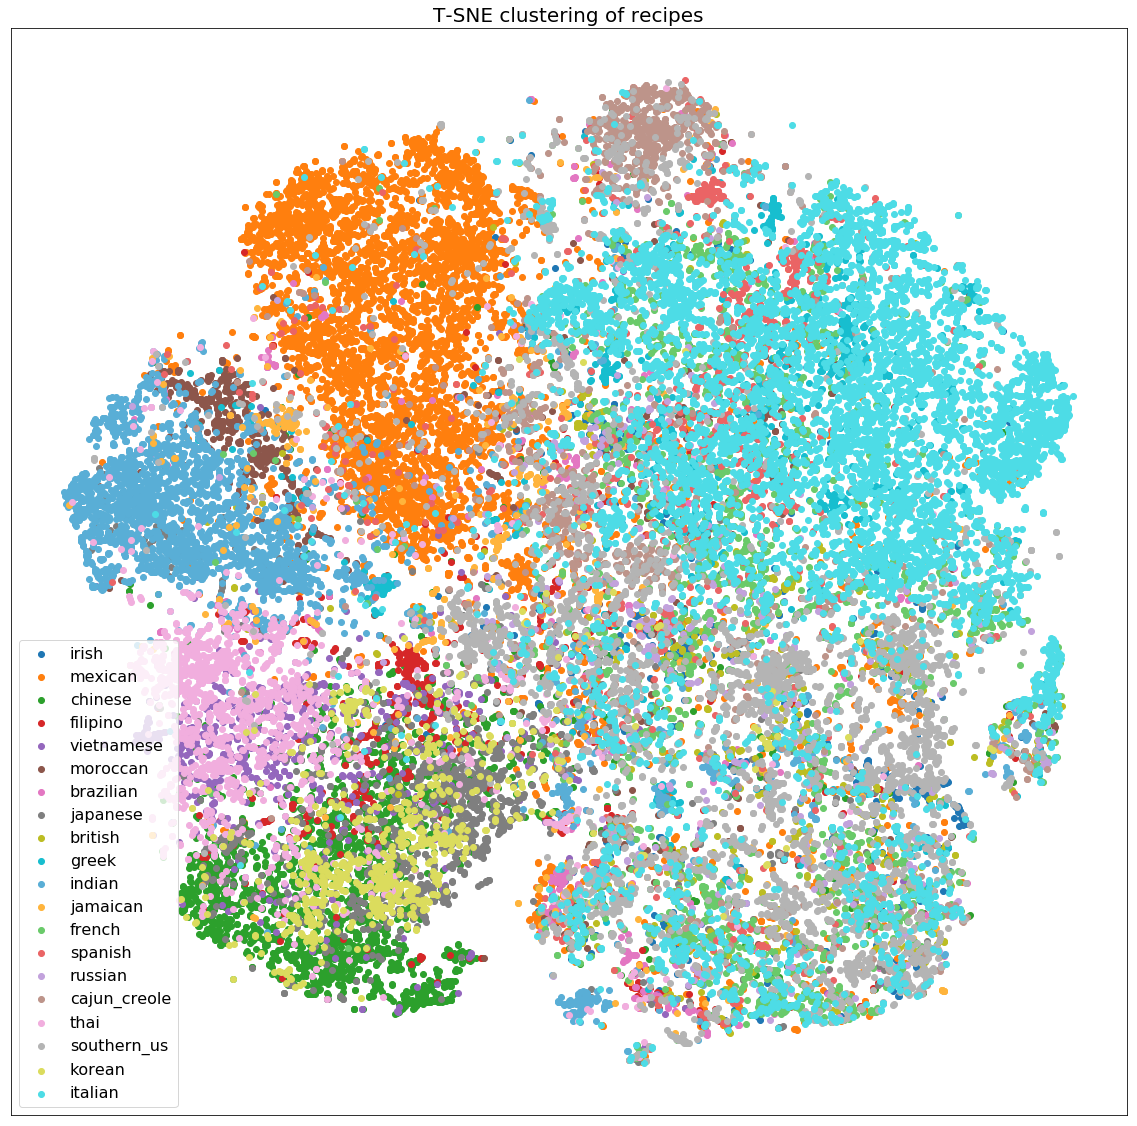

In [770]:
fig = plt.figure(figsize=(20,20));
for c,color in zip(cuisine_unique,colors):
    c_id = cuis_id_dict[c]
    mask = np.array(cuis_id)==c_id
    
    plt_obj = plt.scatter(embed_vec[mask,0],embed_vec[mask,1],color=color)
    plt.title('T-SNE clustering of recipes',fontsize=20)
    plt.xticks([])
    plt.yticks([])
plt.legend(labels=cuisine_unique,fontsize=16)


not too shabby. now we need to train a classifier. we can use LIME or test individual ingredients to find importance in cuisine.

start by making a train test split, then train KNN model on training data

In [771]:
x_train,x_test,y_train,y_test = train_test_split(vec,cuisine_list)

In [772]:
model = KNeighborsClassifier(n_neighbors=5,weights='distance')
model.fit(x_train,y_train)
pred = model.predict(x_test)
accuracy = metrics.accuracy_score(y_test,pred)
f1 = metrics.f1_score(y_test,pred,average='micro')
print 'accuracy: %.2f' % accuracy

accuracy: 0.68


nice.

let's see where we made mistakes by making a nice confusion matrix plot

In [773]:
def plot_confusion_matrix(y_test,pred,classes,fig_size=(20,20),font_size=20,label_size=32):
    cm = metrics.confusion_matrix(y_test,pred)
    cm_norm = cm.astype('float')/np.sum(cm,axis=1)[:,np.newaxis]
    plt.figure(figsize=fig_size);
    plt.imshow(cm_norm, cmap=plt.cm.Blues)
    plt.title('Confusion Matrix',fontsize=label_size)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=font_size)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=font_size)
    plt.yticks(tick_marks, classes,fontsize=font_size)
    plt.tight_layout()
    plt.ylabel('True label',fontsize=label_size)
    plt.xlabel('Predicted label',fontsize=label_size)
    thresh = cm_norm.max() / 1.5
    for i, j in itertools.product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
        plt.text(j, i, "{:0.2f}".format(cm_norm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm_norm[i, j] > thresh else "black")

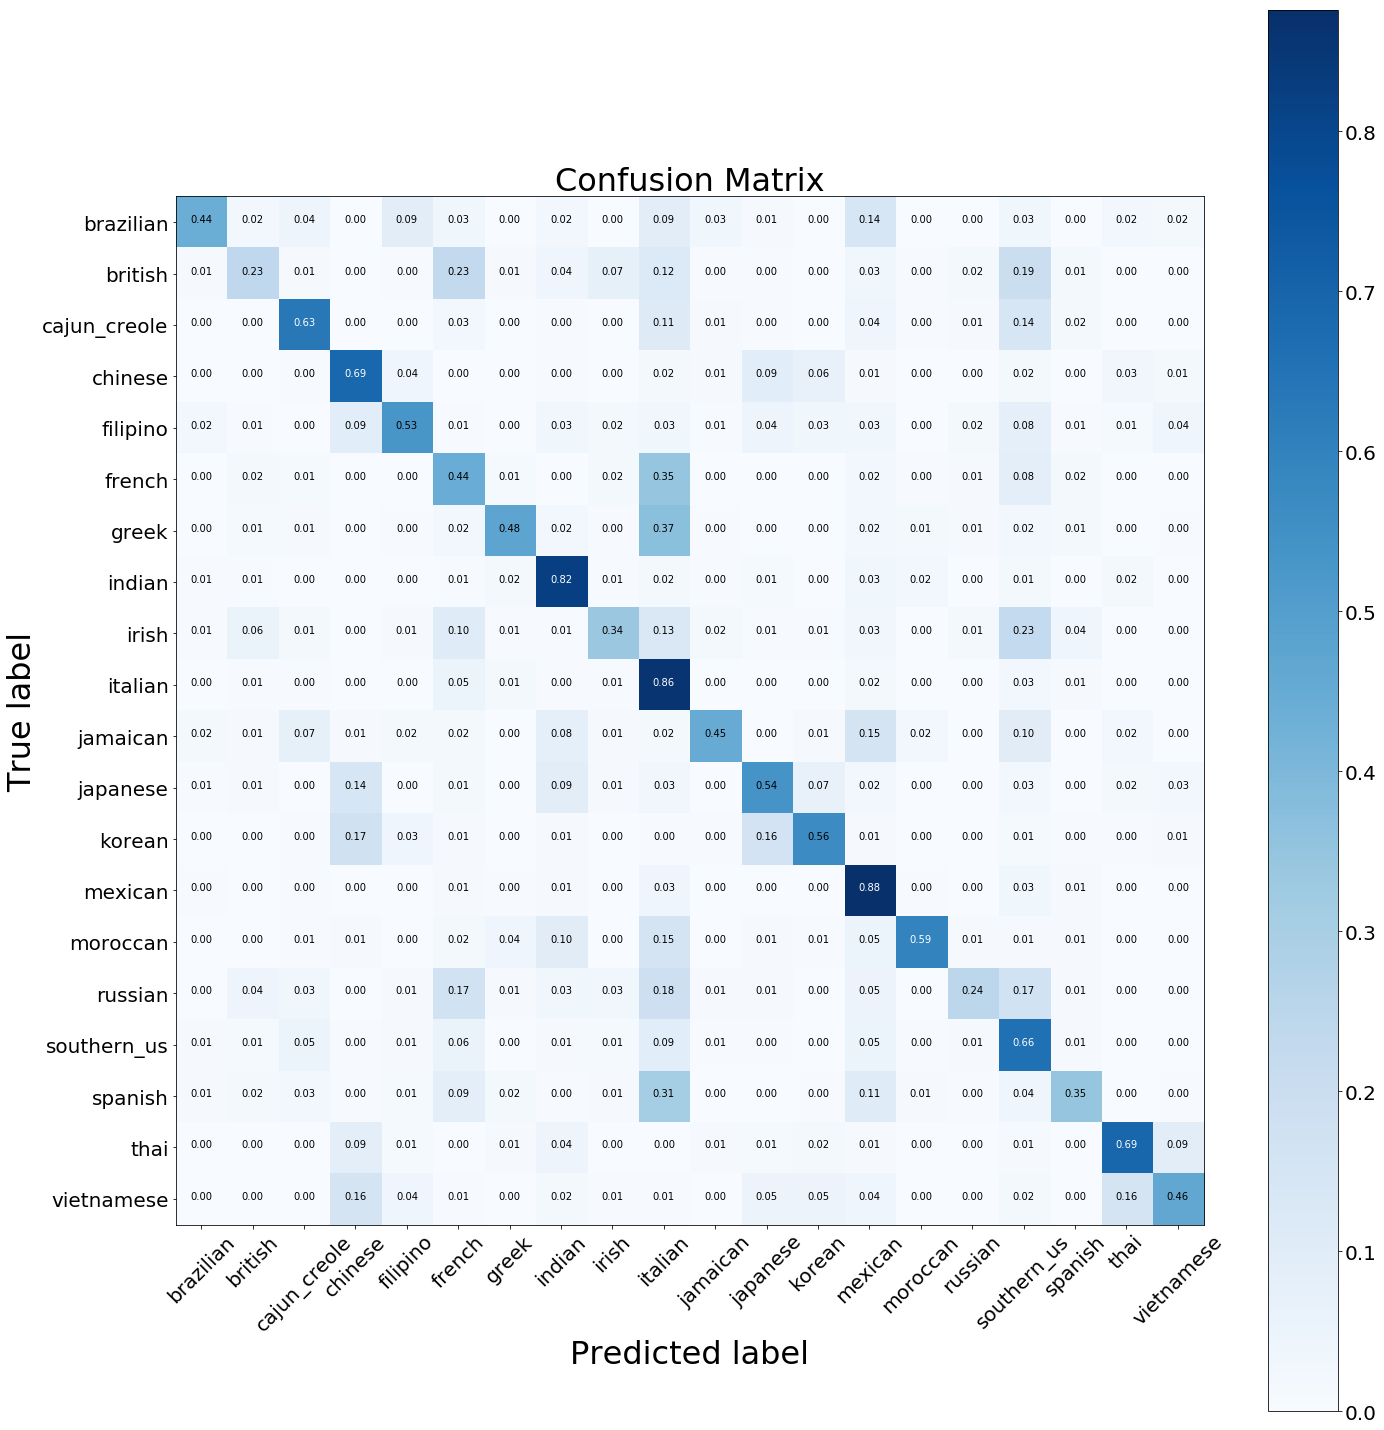

In [774]:
plot_confusion_matrix(y_test,pred,model.classes_)

model does a decent job, biased toward over-represented classes. Does a good job predicting distinct groups with large examples: italian, mexican, indian, and chinese. A possible option would be to use heirarchical models to better distinguish Spanish, French, and Greek from Italian, and Japanese, Korean, and Thai from Chinese. The model predicts the group correctly (western european or eastern asian) but then consistently predicts the most common member of that group (Italian and Chinese). Let's see if we can narrow in on which words guide our predictions and cause misclassifications.

In [ ]:
norm_vec = []
for v in vec:
    norm_vec.append(v/sum(v**2)**0.5)
norm_vec = np.array(norm_vec)
x_train,x_test,y_train,y_test = train_test_split(norm_vec,cuisine_list)
model = KNeighborsClassifier(n_neighbors=5,weights='distance')
model.fit(x_train,y_train)
pred = model.predict(x_test)
accuracy = metrics.accuracy_score(y_test,pred)
f1 = metrics.f1_score(y_test,pred,average='micro')
print 'accuracy: %.2f' % accuracy

Let's use a random forest model instead so that we can implement a LIME algorithm to obtain interpretability using local perturbations. LIME method requires the model be able to output probabilities for prediction classes. We also need to save the untransformed version of our test set in order to do perturbations

In [775]:
x_train,x_test,y_train,y_test = train_test_split(corpus,cuisine_list)
x_train_trans = [np.sum(vec_model.wv[doc],axis=0) for doc in x_train]
x_test_trans = [np.sum(vec_model.wv[doc],axis=0) for doc in x_test]

In [776]:

rf = RandomForestClassifier(max_depth=20,max_features='sqrt',n_estimators=100)
rf.fit(x_train_trans,y_train)
rf_pred = rf.predict(x_test_trans)
rf_prob = rf.predict_proba(x_test_trans)
accuracy = metrics.accuracy_score(y_test,rf_pred)
print 'accuracy: %.2f' %accuracy

accuracy: 0.68


We're going to make a feature vectorizing class that we can implement in our pipeline. This allows us to plug in a list of tokens and output the predictions and the vectorization is taking place behind the scenes in our pipeline

In [777]:
class feature_vectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, model):
        self.model = model

    def transform(self, X, *_):
        if isinstance(X,basestring):
            len_out = 1
            string = True
        else:
            len_out = len(X)
            string = False
            
        vec_array = np.zeros([len_out,self.model.vector_size])
        for i in range(len_out):
            if string:
                x = X
            else:
                x = X[i]
            split_x = re.findall('\w+',x)
            new_x = [w for w in split_x if w in self.model.wv.vocab]
            if new_x:
                vec = np.sum(self.model.wv[new_x],axis=0)
                vec_array[i,:] = vec
        return vec_array

    def fit(self, *_):
        return self
    


In [778]:
fv = feature_vectorizer(vec_model)
c = make_pipeline(fv,rf)
explainer = LimeTextExplainer(class_names=rf.classes_)

In [781]:
feature_dict = {}
n_lime = 100
n_exp = 10
for x,y,p in itertools.izip(x_test[:n_lime],y_test[:n_lime],rf_pred[:n_lime]):
    p_idx = np.where(rf.classes_==p)[0][0]
    exp = explainer.explain_instance(' '.join(x),c.predict_proba,num_features=len(x),labels=[p_idx])
    lime_list = exp.as_list(label=p_idx)
    if p not in feature_dict:
        feature_dict[p] = {'correct':[],'incorrect':[]}
    if p==y:
        classify = 'correct'
    else:
        classify = 'incorrect'
    lime_sort = sorted(lime_list, key=lambda x:x[1],reverse=True)
    for ing,score in lime_sort[:n_exp]:
        if score>0:
            feature_dict[p][classify].append(ing)

In [829]:
exp = explainer.explain_instance(' '.join(x_test[0]), c.predict_proba,num_features=len(x_test[0]),labels=np.where(rf.classes_==y_test[0])[0])
exp.show_in_notebook()

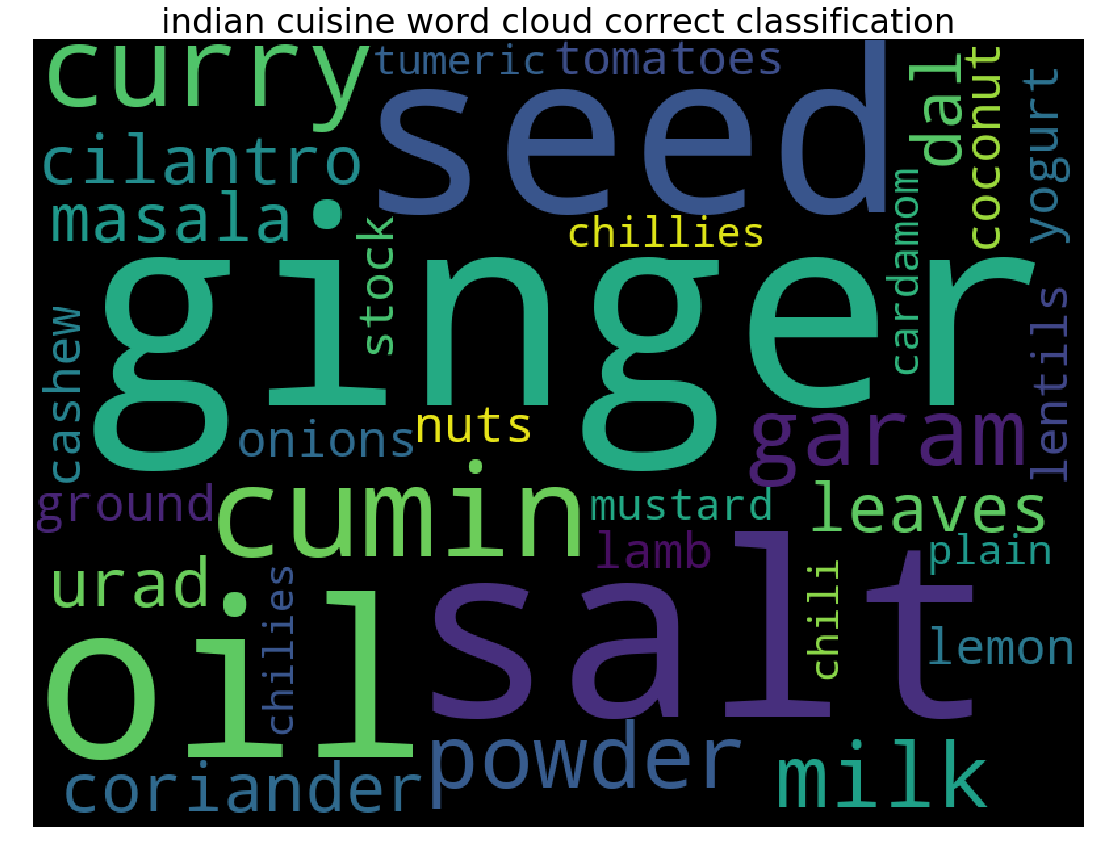

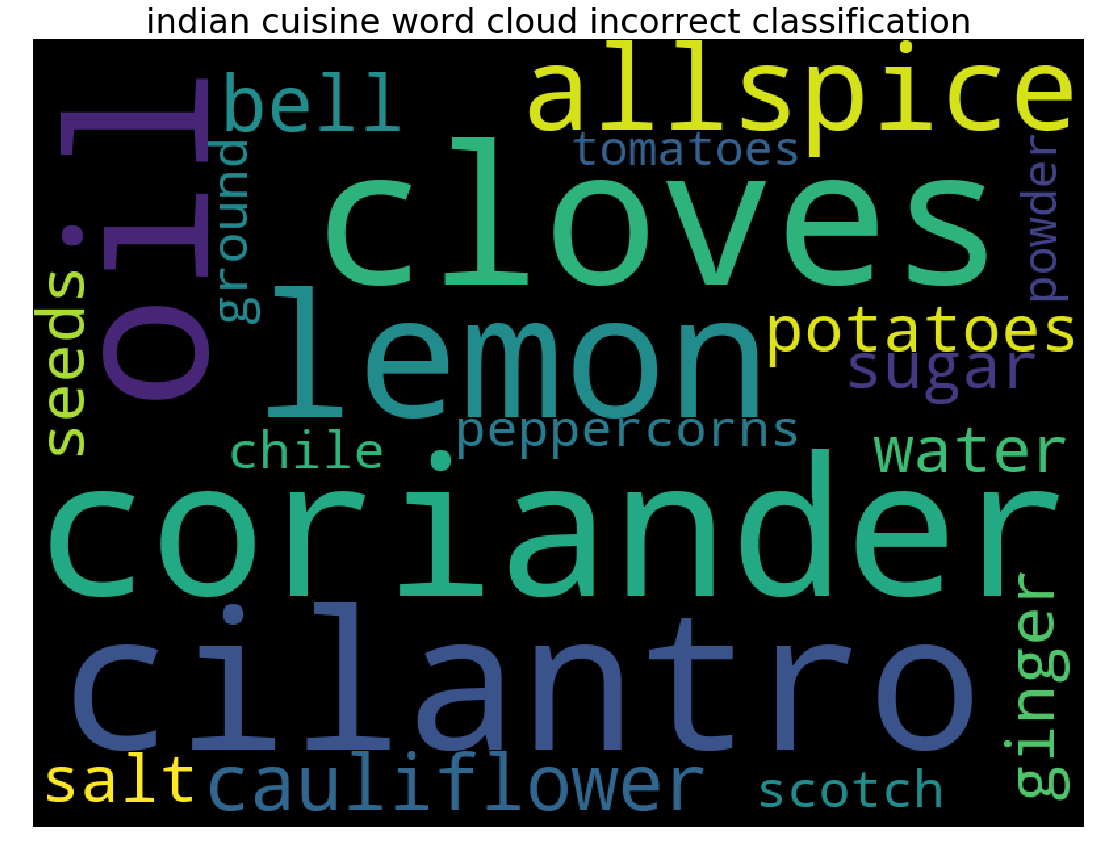

In [830]:
wc_cuisine = 'indian'
fontsize = 34
wc = wordcloud.WordCloud(width=800,height=600).generate(' '.join(feature_dict[wc_cuisine]['correct'])) 
plt.figure(figsize=(15,20))
plt.imshow(wc)
plt.title(wc_cuisine + ' cuisine word cloud correct classification',fontsize=fontsize)
plt.axis("off") 
plt.tight_layout(pad = 0) 

wc = wordcloud.WordCloud(width=800,height=600).generate(' '.join(feature_dict[wc_cuisine]['incorrect'])) 
plt.figure(figsize=(15,20))
plt.imshow(wc)
plt.title(wc_cuisine + ' cuisine word cloud incorrect classification',fontsize=fontsize)
plt.axis("off") 
plt.tight_layout(pad = 0)

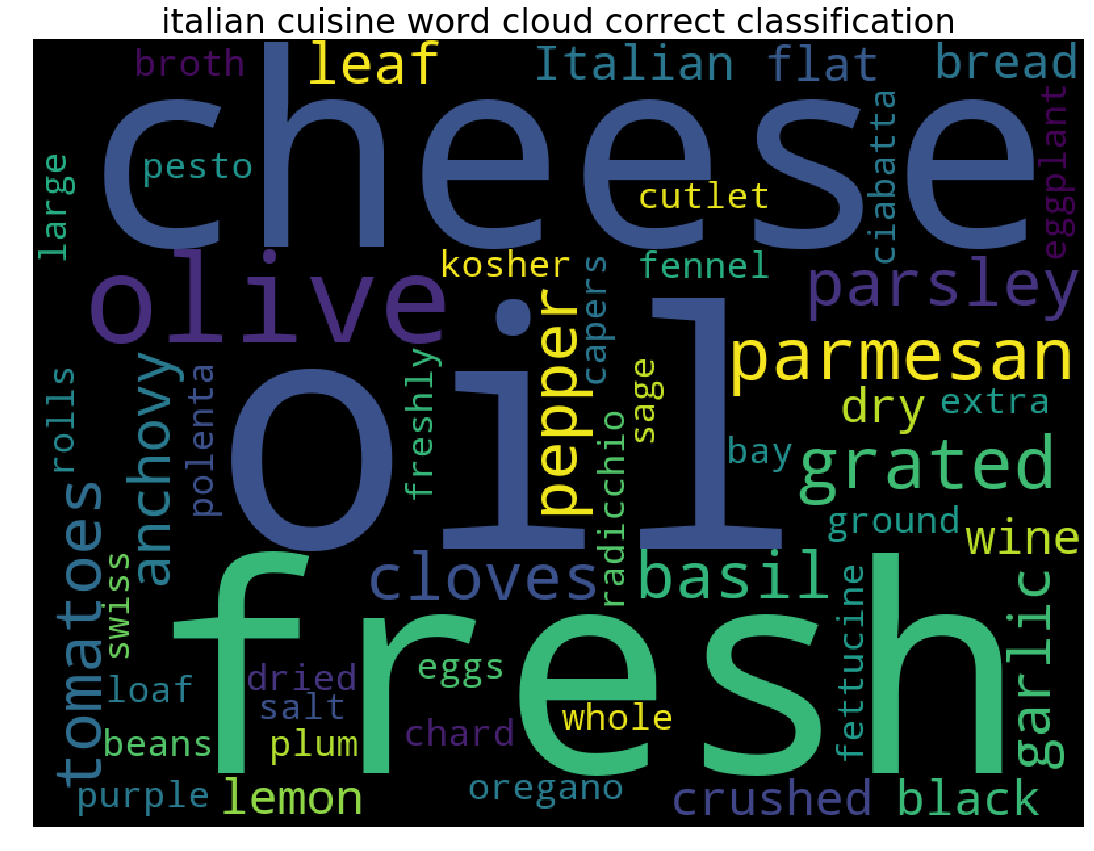

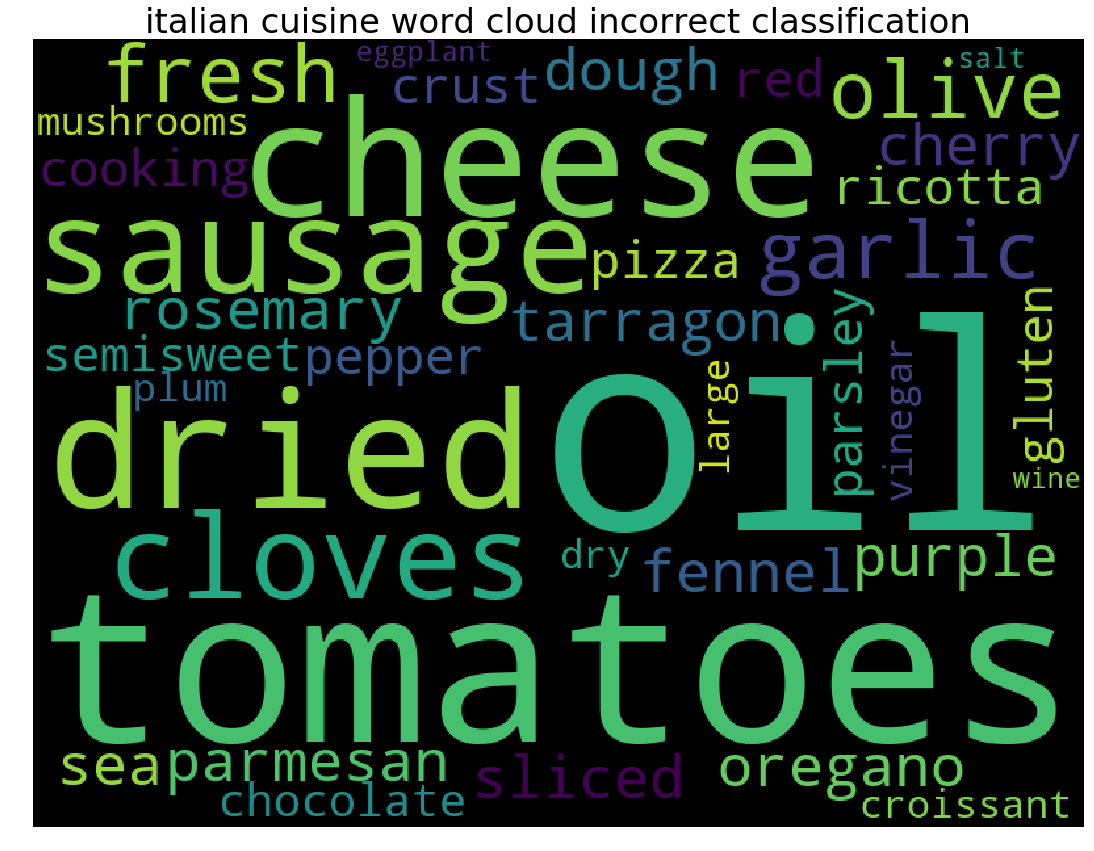

In [820]:
wc_cuisine = 'italian'
fontsize = 34
wc = wordcloud.WordCloud(width=800,height=600).generate(' '.join(feature_dict[wc_cuisine]['correct'])) 
plt.figure(figsize=(15,20))
plt.imshow(wc)
plt.title(wc_cuisine + ' cuisine word cloud correct classification',fontsize=fontsize)
plt.axis("off") 
plt.tight_layout(pad = 0) 

wc = wordcloud.WordCloud(width=800,height=600).generate(' '.join(feature_dict[wc_cuisine]['incorrect'])) 
plt.figure(figsize=(15,20))
plt.imshow(wc)
plt.title(wc_cuisine + ' cuisine word cloud incorrect classification',fontsize=fontsize)
plt.axis("off") 
plt.tight_layout(pad = 0)

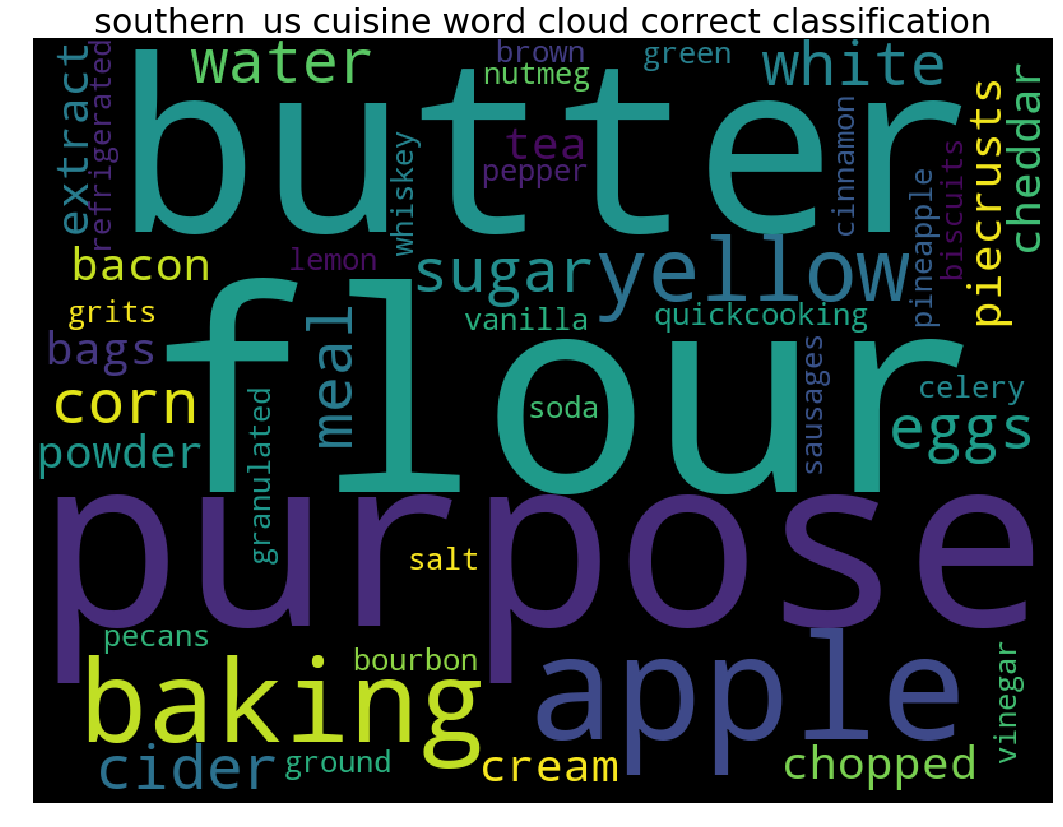

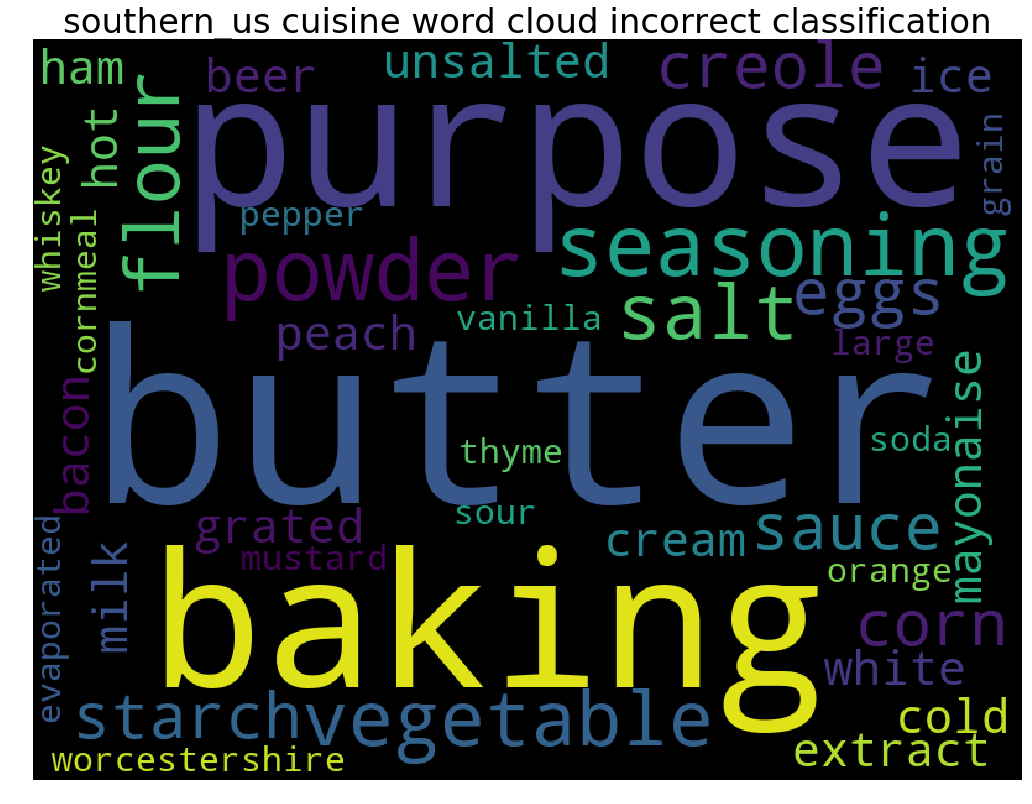

In [831]:
wc_cuisine = 'southern_us'
fontsize = 34
wc = wordcloud.WordCloud(width=800,height=600).generate(' '.join(feature_dict[wc_cuisine]['correct'])) 
plt.figure(figsize=(15,20))
plt.imshow(wc)
plt.title(wc_cuisine + ' cuisine word cloud correct classification',fontsize=fontsize)
plt.axis("off") 
plt.tight_layout(pad = 0) 

wc = wordcloud.WordCloud(width=800,height=600).generate(' '.join(feature_dict[wc_cuisine]['incorrect'])) 
plt.figure(figsize=(15,20))
plt.imshow(wc)
plt.title(wc_cuisine + ' cuisine word cloud incorrect classification',fontsize=fontsize)
plt.axis("off") 
plt.tight_layout(pad = 0)

    model